In [45]:
import numpy as np
import matplotlib.pyplot as plt

from Experiment.create_prepared_data_tsfresh import *
from Experiment.compression import calculateCompRatio, compress_dataset
from utils.personal_utils import *

import matplotlib.pyplot as plt

from paretoset import paretoset

Important:
- When I include the first value, not all 3 first points are included, but only dct at current implementation! This is bad! 
-> If I include it or not doesn't change the ranking! Either each tq one point more or each one point less! -> For me only changes, bc unfair implementation

To exclude first value: 
- - Delete from dropout. - when loading comp_ratio put np.load(...)[1:] in both loading things - but do not do [1:] in the graph, then we don't start anymore in the beginning!
-> Plot graph with first value, calculate other without! Same output!



WARNING:
- In Create pareto_values dict and in plotting it we use the pre-saved comp_ratio values for our pre_defined/usual dropout_values. 
-> IF I CHANGE THE COMPRESSION CODE OR PARTS OF CREATING_AND_PREPARE_DATA, I PROBABLY HAVE TO RELOAD THE RMSE VALUES

Other things:
- easy to add new metrics
- Graph calculation a little unintuitive, bc we loop over each ds and then each tq and plot for each ds all and tq the two metric graphs at once.

In [46]:
dropout_values = [0, 0.5, 0.75, 0.85, 0.9, 0.95, 0.97, 0.99]
tqs = ['dct', 'dft', 'dwt']

ds_names = [
    'BenzeneConcentration',
    'BeijingPM25Quality',
    'FloodModeling1',
    'BeijingPM10Quality',
    'HouseholdPowerConsumption1',
    'IEEEPPG',
    'Covid3Month',
    
    #'NewsTitleSentiment',
    'AppliancesEnergy',

]

path = '/home/sim/Desktop/TS Extrinsic Regression/PredictionsAllDatasets/'
graph_title = 'FLAML Results'

#path = '/home/sim/Desktop/TS Extrinsic Regression/PredictionsAllDatasets_agluon/'
#graph_title = 'Agluon Results'


In [47]:
# Create a dictionary with the pareto set. pareto_values[(metric, ds_name)] = list of tupels like (dropout,tq,index of the dropout_val in the drpout_val list)

dict = {}

for  ds_name in ds_names:

    y = np.load(f'/home/sim/Desktop/TS Extrinsic Regression/data/Dataset-Arrays/{ds_name}_y_TEST.npy')

    # For each metric: The first list holds each comp_ratios of all tq's one after another. len(tqs) * len(dropout_values). Second list holds the corresponding metric value in same order. Third value holsd for each Index of first two lists the dropout_value and tq_name, and as last value the index of the actual dropout value, to make plotting easy.
    dict[('rmse', ds_name)] = ([], [], [])
    dict[('msmape', ds_name)] = ([], [], [])

    dict[('smape', ds_name)] = ([], [], [])

    dict[('mape', ds_name)] = ([], [], [])

    for tq in tqs:
        comp_ratios = np.empty_like(dropout_values)
        rmse = np.empty_like(dropout_values)
        mape = np.empty_like(dropout_values)
        smape = np.empty_like(dropout_values)
        msmape = np.empty_like(dropout_values)


        for i, dropout in enumerate(dropout_values):
            if dropout == 0:
                prediction =  np.load(path + ds_name + '/' + f"NONE_{ds_name}_predictions.npy")
            else:
                prediction = np.load(path + ds_name + '/' + f"{dropout}_{tq}_{ds_name}_predictions.npy")
                
            rmse[i] = get_rmse(y, prediction)
            mape[i] = get_mape(y, prediction)
            smape[i] = get_smape(y, prediction)
            msmape[i] = get_msmape(y, prediction)



            dict[('rmse', ds_name)][2].append((dropout,tq, i))
            dict[('msmape', ds_name)][2].append((dropout,tq, i))

            dict[('smape', ds_name)][2].append((dropout,tq, i))
            dict[('mape', ds_name)][2].append((dropout,tq, i))


        comp_ratios = np.load('/home/sim/Desktop/TS Extrinsic Regression/data/Comp_Ratios/' + f'{ds_name}_{tq}_TRAIN.npy') #[1:]

        # We do not save to which tq the combination owes, we can infer that! -> if wanted, save it all in a dictionary
        dict[('rmse', ds_name)][0].extend(comp_ratios)
        dict[('rmse', ds_name)][1].extend(rmse)
        

        dict[('msmape', ds_name)][0].extend(comp_ratios)
        dict[('msmape', ds_name)][1].extend(msmape)


        dict[('smape', ds_name)][0].extend(comp_ratios)
        dict[('smape', ds_name)][1].extend(smape)

        dict[('mape', ds_name)][0].extend(comp_ratios)
        dict[('mape', ds_name)][1].extend(mape)




    
pareto_values = {}

#print(dict[('msmape', ds_name)])
#print(dict)


for (metric, ds_name), arr_list_tpl in dict.items():
    points = pd.DataFrame({"comp_ratios": arr_list_tpl[0],
                          "metric": arr_list_tpl[1]})
    #print(points)
    
    mask = paretoset(points, sense=["max", "min"])
    #print(mask)
    paretoset_points = points[mask]
    #print(paretoset_points)

    masked_list = [e for e, mask_val in zip(arr_list_tpl[2], mask) if mask_val] # Mask the list
    #print(masked_list)
    pareto_values[(metric, ds_name)] = masked_list


for ds_name in ds_names: 
    print(f'{ds_name} {pareto_values[("smape",ds_name)]}')


BenzeneConcentration [(0, 'dct', 0), (0.5, 'dct', 1), (0.97, 'dct', 6), (0.99, 'dct', 7), (0.97, 'dft', 6), (0.99, 'dft', 7), (0.5, 'dwt', 1), (0.75, 'dwt', 2), (0.85, 'dwt', 3), (0.9, 'dwt', 4), (0.97, 'dwt', 6), (0.99, 'dwt', 7)]
BeijingPM25Quality [(0, 'dct', 0), (0.5, 'dct', 1), (0.95, 'dct', 5), (0.97, 'dct', 6), (0.5, 'dft', 1), (0.75, 'dft', 2), (0.85, 'dft', 3), (0.9, 'dft', 4), (0.95, 'dft', 5), (0.5, 'dwt', 1), (0.75, 'dwt', 2), (0.9, 'dwt', 4), (0.95, 'dwt', 5), (0.97, 'dwt', 6), (0.99, 'dwt', 7)]
FloodModeling1 [(0.99, 'dft', 7), (0.5, 'dwt', 1), (0.75, 'dwt', 2), (0.85, 'dwt', 3), (0.95, 'dwt', 5), (0.97, 'dwt', 6), (0.99, 'dwt', 7)]
BeijingPM10Quality [(0, 'dct', 0), (0.9, 'dct', 4), (0.75, 'dft', 2), (0.85, 'dft', 3), (0.9, 'dft', 4), (0.95, 'dft', 5), (0.99, 'dft', 7), (0.95, 'dwt', 5), (0.97, 'dwt', 6), (0.99, 'dwt', 7)]
HouseholdPowerConsumption1 [(0, 'dct', 0), (0.75, 'dct', 2), (0.95, 'dct', 5), (0.5, 'dft', 1), (0.9, 'dft', 4), (0.99, 'dft', 7), (0.5, 'dwt', 1), (0

Pareto Analysis:


In [48]:
# Do not include the no compression point in the pareto_values:

metrics = ['rmse', 'msmape', 'smape', 'mape']

for metric in metrics: 
    print(metric)

    # Reset overall counts for each metric
    overall_counts_tq = {}
    overall_counts_dr = {}

    # Count how often one pareto_value per Dataset
    for ds_name in ds_names:
        tpl_list = pareto_values[(metric, ds_name)]
        only_tq = [e[1] for e in tpl_list]
        only_dr = [e[0] for e in tpl_list]
        
        for value in only_tq:
            if value in overall_counts_tq:
                overall_counts_tq[value] += 1
            else:
                overall_counts_tq[value] = 1

        for value in only_dr:
            if value in overall_counts_dr:
                overall_counts_dr[value] += 1
            else:
                overall_counts_dr[value] = 1

    # Print overall_counts_tq
    print(overall_counts_tq)

    sorted_keys_dr = sorted(overall_counts_dr.keys())
    sorted_overall_counts_dr = {key: overall_counts_dr[key] for key in sorted_keys_dr}
    print(sorted_overall_counts_dr)
    print()


rmse
{'dct': 17, 'dft': 24, 'dwt': 28}
{0: 5, 0.5: 7, 0.75: 5, 0.85: 6, 0.9: 8, 0.95: 10, 0.97: 14, 0.99: 14}

msmape
{'dct': 19, 'dft': 22, 'dwt': 30}
{0: 6, 0.5: 9, 0.75: 8, 0.85: 5, 0.9: 8, 0.95: 7, 0.97: 13, 0.99: 15}

smape
{'dct': 18, 'dft': 21, 'dwt': 30}
{0: 5, 0.5: 9, 0.75: 8, 0.85: 5, 0.9: 8, 0.95: 7, 0.97: 12, 0.99: 15}

mape
{'dct': 10, 'dft': 17, 'dwt': 25}
{0: 3, 0.5: 4, 0.75: 4, 0.85: 5, 0.9: 8, 0.95: 7, 0.97: 8, 0.99: 13}



In [49]:
# Calculate the counts per Dataset and print
# Also creates the df for the wilcoxin cd-diagram -> maybe adapt count values to the lower, the better! if only rank counts!

#metric = "rmse"
#metric = 'msmape'

metric = 'mape'
print(metric)
df = pd.DataFrame(columns=['classifier_name', 'dataset_name', 'accuracy'])


# Count how many one thing per Dataset
for ds_name in ds_names:
    tpl_list = pareto_values[(metric, ds_name)]
    only_tq = [e[1] for e in tpl_list]
    
    # Manually count occurrences
    for tq in ['dwt', 'dft', 'dct']:
        curr_value = 0
        for value in only_tq:
            if value == tq :
                curr_value += 1


        new_row = {'classifier_name': tq  , 'dataset_name': ds_name, 'accuracy':curr_value }
        df = df.append(new_row, ignore_index=True)


df.to_csv(f'{metric}_{graph_title}_count_df.csv', index=False)
df

mape


,classifier_name,dataset_name,accuracy
0,dwt,BenzeneConcentration,5
1,dft,BenzeneConcentration,2
2,dct,BenzeneConcentration,2
3,dwt,BeijingPM25Quality,5
4,dft,BeijingPM25Quality,4
5,dct,BeijingPM25Quality,4
6,dwt,FloodModeling1,6
7,dft,FloodModeling1,1
8,dct,FloodModeling1,0
9,dwt,BeijingPM10Quality,3


In [50]:
# Count how many one thing per Dataset
print(metric)
for ds_name in ds_names:
    tpl_list = pareto_values[(metric, ds_name)]
    only_tq = [e[1] for e in tpl_list]
    
    # Manually count occurrences
    value_counts = {}
    for value in only_tq:
        
        if value in value_counts:
            value_counts[value] += 1
        else:
            value_counts[value] = 1
    
    # Print the counts directly
    print(f"Counts for {ds_name}:")
    for key, count in value_counts.items():
        print(f"{key}: {count}")
    print()  # Add an extra newline for better readability





mape
Counts for BenzeneConcentration:
dct: 2
dft: 2
dwt: 5

Counts for BeijingPM25Quality:
dct: 4
dft: 4
dwt: 5

Counts for FloodModeling1:
dft: 1
dwt: 6

Counts for BeijingPM10Quality:
dct: 2
dft: 4
dwt: 3

Counts for HouseholdPowerConsumption1:
dft: 2
dwt: 2

Counts for IEEEPPG:
dft: 1

Counts for Covid3Month:
dft: 1

Counts for AppliancesEnergy:
dct: 2
dft: 2
dwt: 4



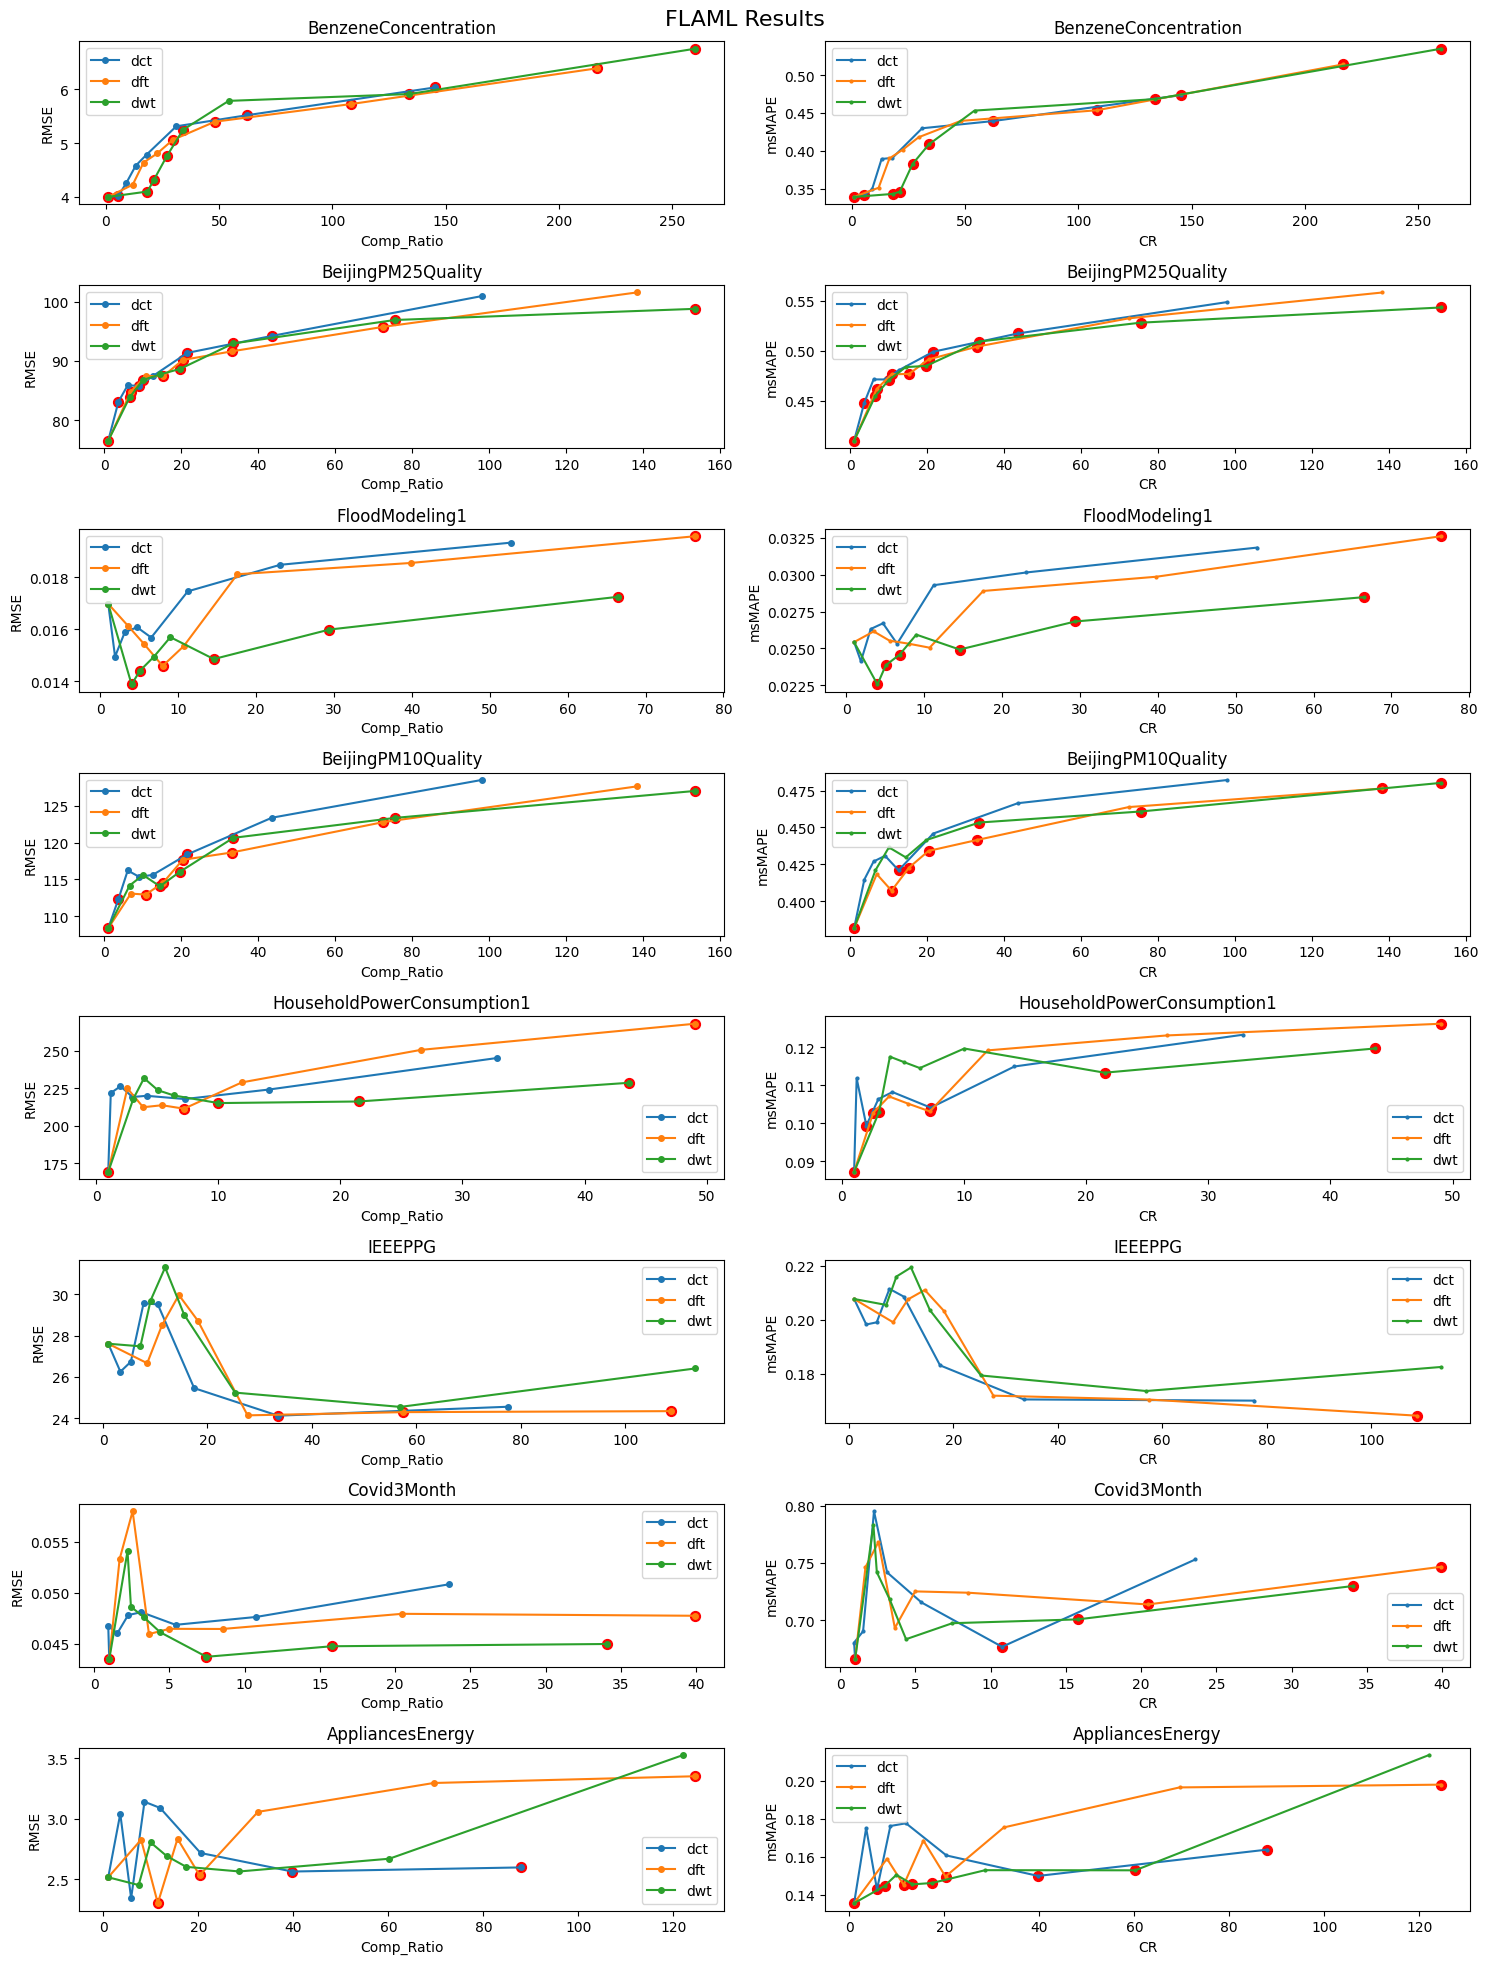

In [51]:
# Plot the Pareto-Set

plt.figure(figsize=(15, 20))  

num_dataset = len(ds_names)

for subplot_id, ds_name in enumerate(ds_names):

    #dataset_array = np.load('/home/sim/Desktop/TS Extrinsic Regression/data/Dataset-Arrays/' + ds_name + '_TRAIN.npy')
    y = np.load(f'/home/sim/Desktop/TS Extrinsic Regression/data/Dataset-Arrays/{ds_name}_y_TEST.npy')


    for tq in tqs:
        comp_ratios = np.empty_like(dropout_values)
        rmse = np.empty_like(dropout_values)
        mape = np.empty_like(dropout_values)
        smape = np.empty_like(dropout_values)
        msmape = np.empty_like(dropout_values)


        for i, dropout in enumerate(dropout_values):
            if dropout == 0:
                prediction =  np.load(path + ds_name + '/' + f"NONE_{ds_name}_predictions.npy")
                comp_ratios[i] = 1 # No Compression, so Comp-Ratio of 1

            else:
                prediction = np.load(path + ds_name + '/' + f"{dropout}_{tq}_{ds_name}_predictions.npy")
                
            rmse[i] = get_rmse(y, prediction)
            mape[i] = get_mape(y, prediction)
            smape[i] = get_smape(y, prediction)
            msmape[i] = get_msmape(y, prediction)


            # This is the time consuming step!
            #if dropout != 0:
            #    comp_ratios[i] = calculateCompRatio(dataset_array, compress_dataset(dataset_array.copy(), ds_name, andDecompress= False, compression_type= tq, compression_param=dropout))


        comp_ratios = np.load('/home/sim/Desktop/TS Extrinsic Regression/data/Comp_Ratios/' + f'{ds_name}_{tq}_TRAIN.npy')

            
        
        # From ds_name go through tupel_list, check if tq is acutal tq, then get the right number indicating the dropout_value, plot these ones as big point! but blue points shwos throug


        tpl_list = pareto_values[("rmse", ds_name)]
        curr_tq_idxs = [idx for (_,curr_tq,idx) in tpl_list if curr_tq == tq]



        plt.subplot(num_dataset,2,subplot_id * 2  + 1)

        plt.scatter(comp_ratios[curr_tq_idxs], rmse[curr_tq_idxs], color='red', s = 50)

        plt.plot(comp_ratios, rmse, label=f"{tq}", marker= 'o', markersize = 4)
        #plt.scatter(comp_ratios, rmse, label=f"{tq}", marker='o', s=20, color='blue')

        plt.xlabel("Comp_Ratio")
        plt.ylabel("RMSE")
        plt.legend()
        plt.title(f'{ds_name}')

        """
        plt.subplot(num_dataset,4,subplot_id * num_dataset + 2)
        plt.plot(comp_ratios, mape, label=f"{tq}", marker= 'o', markersize = 2)
        plt.xlabel("Comp_Ratio")
        plt.ylabel("MAPE")
        plt.legend()
        plt.title(f'{ds_name}')

        plt.subplot(num_dataset,4,subplot_id * num_dataset + 3)
        plt.plot(comp_ratios, smape, label=f"{tq}", marker= 'o', markersize = 2)
        plt.xlabel("Comp_Ratio")
        plt.ylabel("sMAPE")  
        plt.legend()          
        plt.title(f'{ds_name}')             
        """


        tpl_list = pareto_values[("msmape", ds_name)]
        curr_tq_idxs = [idx for (_,curr_tq,idx) in tpl_list if curr_tq == tq]
        
        plt.subplot(num_dataset,2 ,subplot_id * 2  + 2)

        plt.scatter(comp_ratios[curr_tq_idxs], msmape[curr_tq_idxs], color='red', s = 50)
        
        #plt.scatter(comp_ratios, msmape, label=f"{tq}", marker='o', s=20, color='blue')
        plt.plot(comp_ratios, msmape, label=f"{tq}", marker= 'o', markersize = 2)

        plt.xlabel("CR")
        plt.ylabel("msMAPE")  
        plt.legend()          
        plt.title(f'{ds_name}')   
        

plt.suptitle(graph_title, fontsize=16)
plt.tight_layout()

        



In [52]:
def change_ds_name(ds_name):
    # Define the mapping of old names to new names
    name_mapping = {
        'AppliancesEnergy': 'AppliancesEnergy',
        'FloodModeling1': 'Flood',
        'BenzeneConcentration': 'BenzeneConcentration',
        'BeijingPM25Quality': 'ParticulateMatter2.5',
        'IEEEPPG': 'IEEEPPG',
        'HouseholdPowerConsumption1': 'PowerUsage',
        'Covid3Month': 'Covid',
        'BeijingPM10Quality': 'ParticulateMatter10',
    }

    # Apply the mapping to rename the datasets
    return name_mapping[ds_name]


Text(0.5, 1.0, 'AppliancesEnergy')

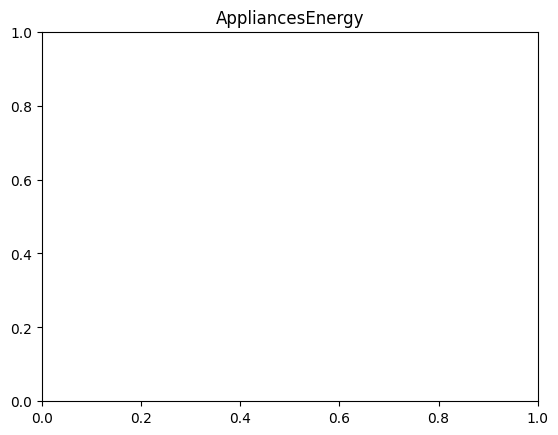

In [53]:
        ds_name_title= change_ds_name(ds_name)
        plt.title(f'{ds_name_title}')

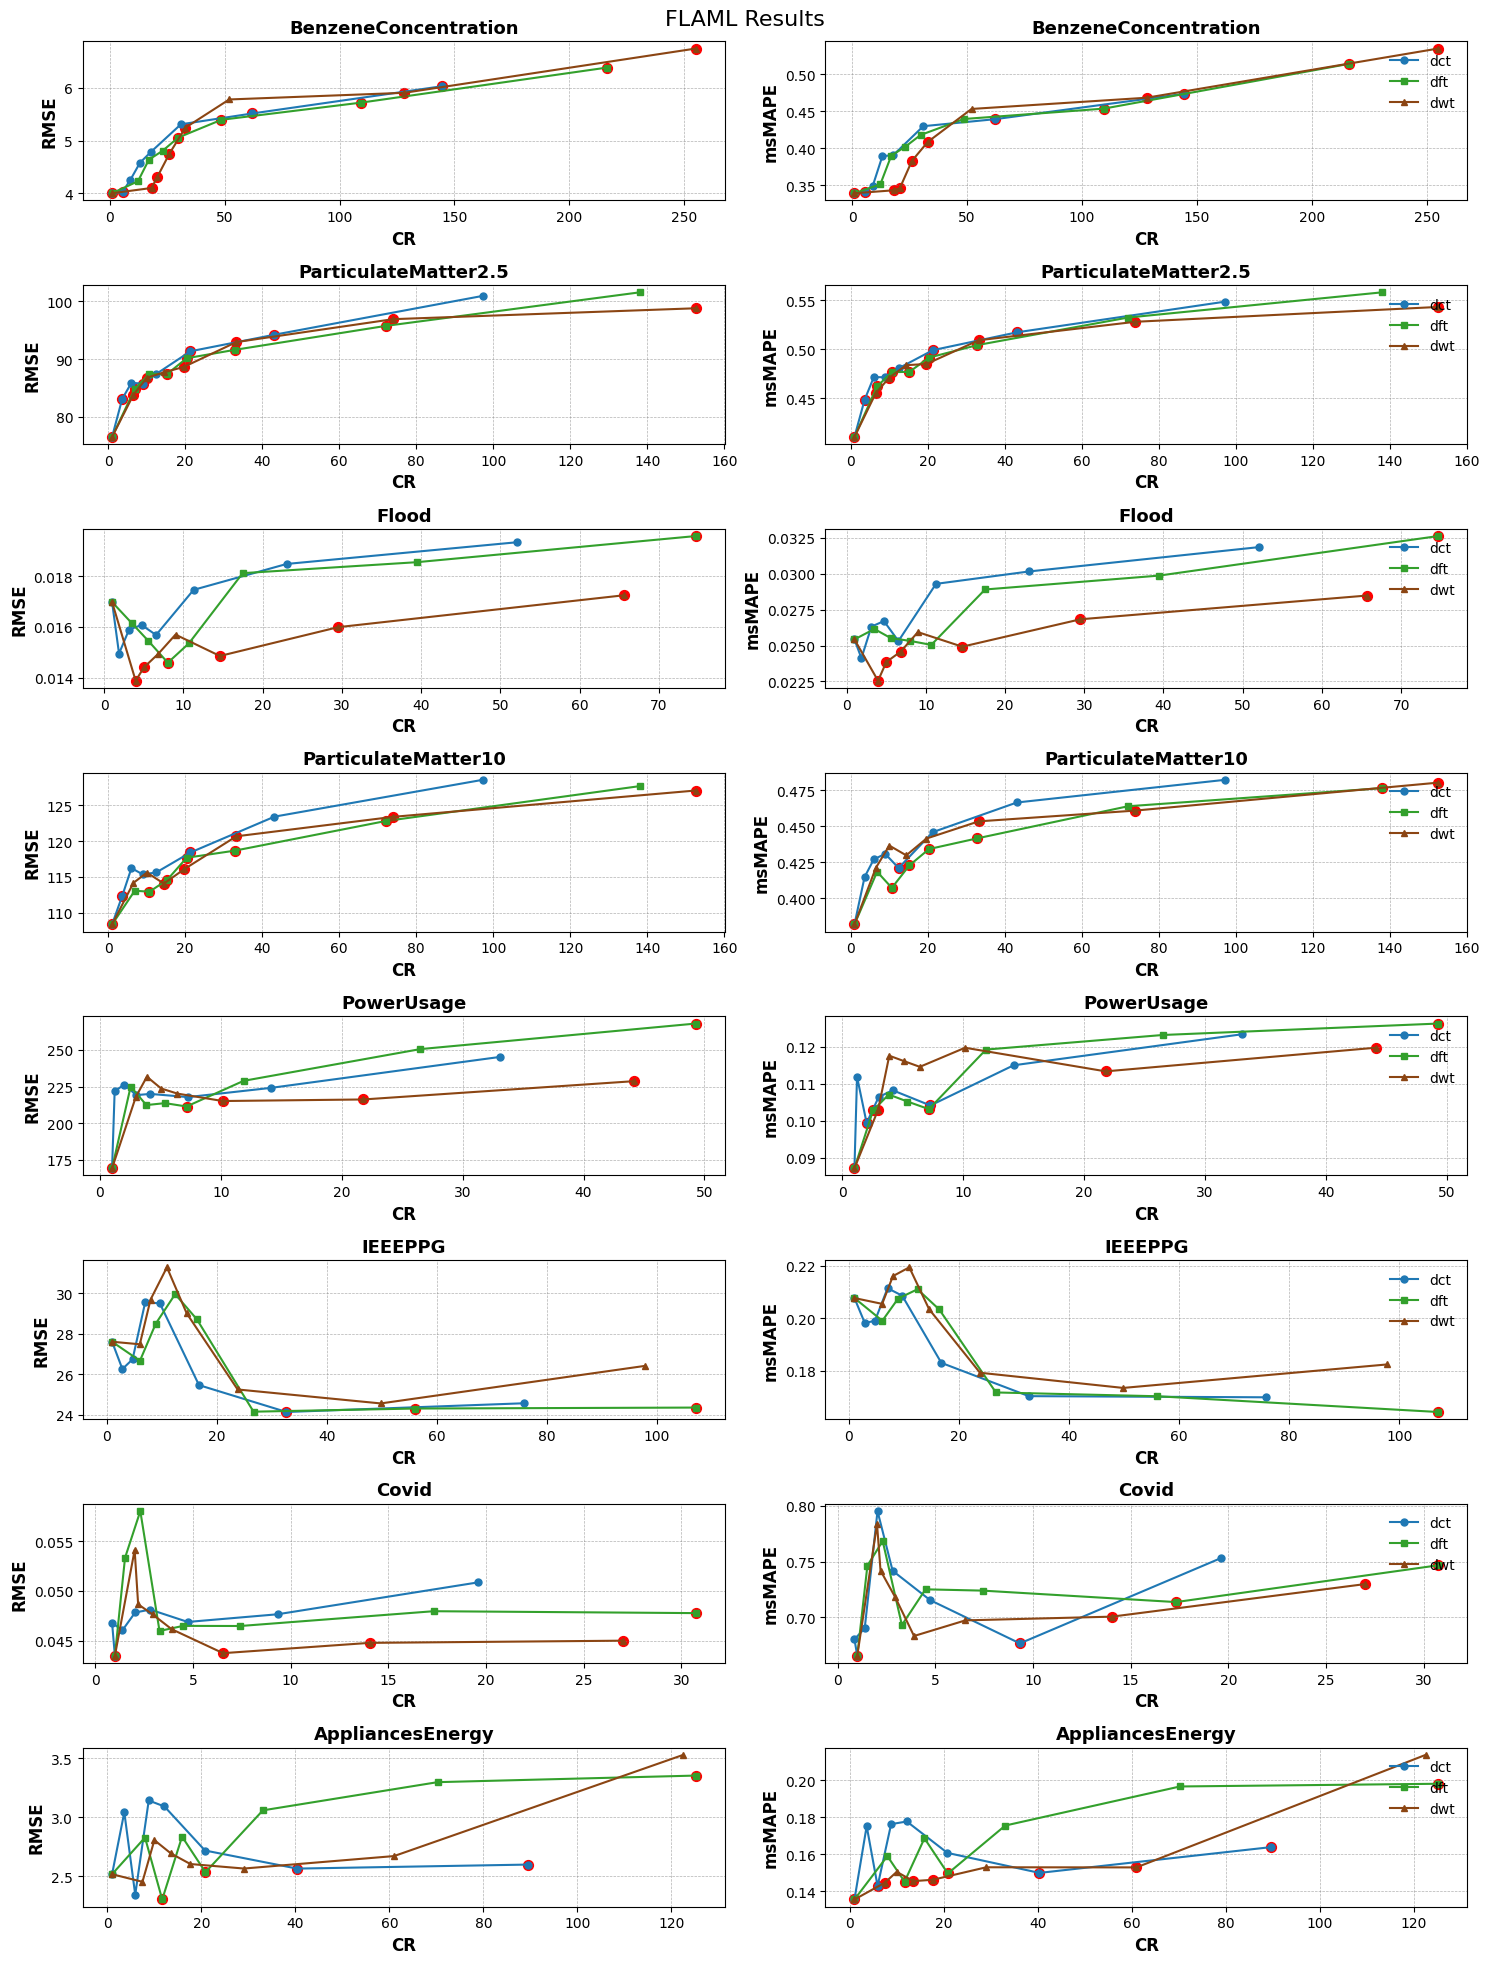

<Figure size 640x480 with 0 Axes>

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define custom colors and markers
colors = ['#1F78B4', '#33A02C', '#8B4513']
markers = ['o', 's', '^']  # Example markers for different tq values

# Plot the Pareto-Set
plt.figure(figsize=(15, 20))

num_dataset = len(ds_names)

for subplot_id, ds_name in enumerate(ds_names):
    y = np.load(f'/home/sim/Desktop/TS Extrinsic Regression/data/Dataset-Arrays/{ds_name}_y_TEST.npy')

    for tq, color, marker in zip(tqs, colors, markers):
        # Prepare arrays
        comp_ratios = np.empty_like(dropout_values)
        rmse = np.empty_like(dropout_values)
        msmape = np.empty_like(dropout_values)

        for i, dropout in enumerate(dropout_values):
            if dropout == 0:
                prediction = np.load(path + ds_name + '/' + f"NONE_{ds_name}_predictions.npy")
                comp_ratios[i] = 1  # No Compression
            else:
                prediction = np.load(path + ds_name + '/' + f"{dropout}_{tq}_{ds_name}_predictions.npy")
            
            # Calculate metrics
            rmse[i] = get_rmse(y, prediction)
            msmape[i] = get_msmape(y, prediction)

        # Load precomputed compression ratios
        comp_ratios = np.load(f'/home/sim/Desktop/TS Extrinsic Regression/data/Comp_Ratios/{ds_name}_{tq}_TRAIN.npy')

        # Extract Pareto values for red dots
        tpl_list = pareto_values[("rmse", ds_name)]
        curr_tq_idxs = [idx for (_, curr_tq, idx) in tpl_list if curr_tq == tq]

        ds_name_title= change_ds_name(ds_name)

        # Plot RMSE
        plt.subplot(num_dataset, 2, subplot_id * 2 + 1)
        plt.scatter(comp_ratios[curr_tq_idxs], rmse[curr_tq_idxs], color='red', s=50)  # Red highlight points
        plt.plot(comp_ratios, rmse, color=color, marker=marker, markersize=5, label=f"{tq}")
        plt.xlabel("CR", fontsize=12, fontweight='bold')
        plt.ylabel("RMSE", fontsize=12, fontweight='bold')
        plt.title(f'{ds_name_title}', fontsize=13, fontweight='bold')
        plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

        # Plot msMAPE
        tpl_list = pareto_values[("msmape", ds_name)]
        curr_tq_idxs = [idx for (_, curr_tq, idx) in tpl_list if curr_tq == tq]

        plt.subplot(num_dataset, 2, subplot_id * 2 + 2)
        plt.scatter(comp_ratios[curr_tq_idxs], msmape[curr_tq_idxs], color='red', s=50)  # Red highlight points
        plt.plot(comp_ratios, msmape, color=color, marker=marker, markersize=5, label=f"{tq}")
        plt.xlabel("CR", fontsize=12, fontweight='bold')
        plt.ylabel("msMAPE", fontsize=12, fontweight='bold')
        plt.title(f'{ds_name_title}', fontsize=13, fontweight='bold')
        plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

    plt.legend(loc="upper right", frameon=False)  # No legend for red dots

plt.suptitle(graph_title, fontsize=16)
plt.tight_layout()
plt.show()

save_dir = "../plots/Pareto"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(f'{save_dir}/winner_TEST_plot.pdf', format='pdf')
